In [1]:
# Import libraries necessary for this project
import pandas as pd
import os
import csv
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from scipy import interp
from sklearn.utils import shuffle
from sklearn.calibration import calibration_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn import cross_validation, metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

%matplotlib inline

/Users/kgjaeringen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Ensure correct data folder is linked before the data file is uploaded.
os.chdir('/Users/kgjaeringen/Documents/Machine Learning/Udacity/01 Course Code/02 Projects/07 Capstone/03 Data')

# Load data
data = pd.read_csv("main_analysis_data_2.csv", header=0)

data.shape

(887350, 54)

In [3]:
df_14 = data.loc[data.Completion_Date == 2014]
#df_15 = data.loc[data.Completion_Date == 2015]

In [4]:
df_14.shape
#df_15.shape

(235628, 54)

In [5]:
X_14 = df_14.drop(["Loan_Status"], axis=1)
Y_14 = df_14.Loan_Status.values

#X_15 = df_15.drop(["Loan_Status"], axis=1)
#Y_15 = df_15.Loan_Status.values


In [6]:
X_14.shape

#X_15.shape


(235628, 53)

In [7]:
# Load data
main_data = pd.read_csv("main_analysis_data_3.csv", header=0)

In [8]:
X_main = main_data.drop(["Loan_Status"], axis=1)
Y_main = main_data.Loan_Status.values

Xnames = X_main.columns

X = X_main.as_matrix()

In [9]:
test_size = 0.40

#Random state defined
seed = 7

X_train, X_test, Y_train, Y_test = train_test_split(X_main, Y_main, test_size=test_size, random_state=seed)

In [10]:
plt.rcParams['figure.figsize'] = 12, 4

In [ ]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
X_res, y_res = cc.fit_sample(X_train, Y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

LR = LogisticRegression(C=0.01)
RFC = RandomForestClassifier(n_estimators=100, bootstrap=True)

plot_ROC_curve(LR, X_res, y_res)
plot_ROC_curve(RFC, X_res, y_res)


Resampled dataset shape Counter({0: 72515, 1: 72515})


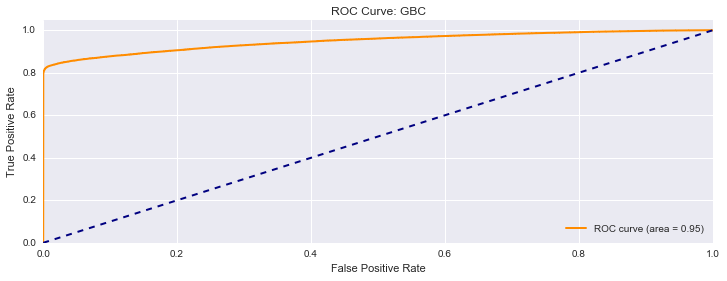

In [15]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE()
X_res, y_res = smote.fit_sample(X_train, Y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

#plot_ROC_curve(GBC, X_res, y_res)

X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, test_size=test_size, random_state=seed)

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
clf = GradientBoostingClassifier(learning_rate=0.01,
                                 n_estimators=110, 
                                 max_depth=9, 
                                 min_samples_split=1500, 
                                 min_samples_leaf=50, 
                                 subsample=0.8, 
                                 random_state= seed,
                                 max_features=7)


clf.fit(X_train, Y_train)
    
y_predict_probabilities = clf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(Y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: GBC')
plt.legend(loc="lower right")
plt.show()

In [16]:
predictions = clf.predict(X_test)
print(classification_report(Y_test,predictions))

             precision    recall  f1-score   support

          0       0.86      0.98      0.92     29024
          1       0.98      0.84      0.90     28988

avg / total       0.92      0.91      0.91     58012



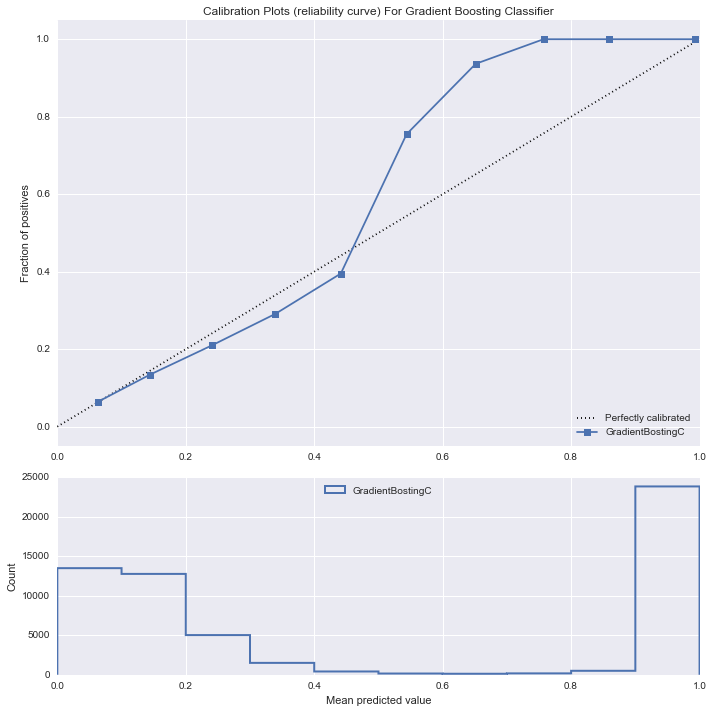

In [19]:
X_train = X_train
X_test = X_test
y_train = Y_train
y_test = Y_test

# Create classifiers
gbc = GradientBoostingClassifier(learning_rate=0.14,
                                 n_estimators=110, 
                                 max_depth=9, 
                                 min_samples_split=3200, 
                                 min_samples_leaf=50, 
                                 subsample=0.8, 
                                 random_state= seed,
                                 max_features=7)

# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(gbc, 'GradientBostingC')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration Plots (reliability curve) For Gradient Boosting Classifier')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

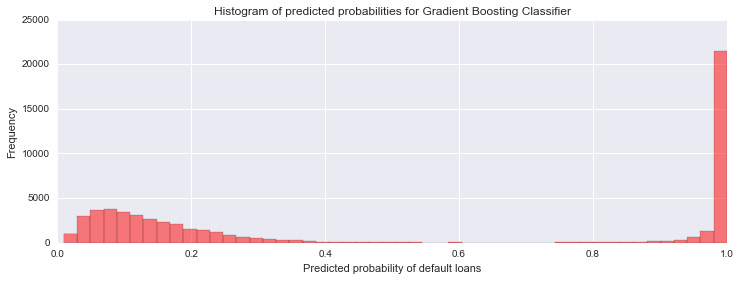

In [20]:
#Histogram for the predicted probabilities
plt.hist(gbc.predict_proba(X_test)[:, 1], bins=50, alpha=0.5, color='r')

plt.xlim(0,1)
plt.title('Histogram of predicted probabilities for Gradient Boosting Classifier')
plt.xlabel('Predicted probability of default loans')
plt.ylabel('Frequency')